In [2]:
import numpy as np
import os
import graphviz
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def partition(x):
    d = {}
    for i in range(len(x)):
        if (d.get(x[i]) == None):
            d.update({x[i]: [i]})
        else:
            d.get(x[i]).append(i)
    
    return d

def entropy(y):
    h = 0
    val, cnt = np.unique(y,  return_counts=True)
    for c in cnt:
        h = h + (c/len(y))*(math.log(c/len(y),2))
    return -h
    raise Exception('Function not yet implemented!')


def mutual_information(x, y):
    eny = entropy(y)
    mi = 0
    val, cnt = np.unique(x,  return_counts=True)
    for v in val:
        newy1 = y[np.where(x==v)[0]]
        newy2 = y[np.where(x!=v)[0]]
        mi = (eny - ((len(newy1)/len(y))*(entropy(newy1))+((len(newy2))/len(y))*entropy(newy2)))
    
    return mi

    raise Exception('Function not yet implemented!')


def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    val, cnt = np.unique(y,  return_counts=True)

    val, cnt = np.unique(y,  return_counts=True)

    if len(val) == 1:
        return val[0]
    if  depth==max_depth or x.shape[1] == 0:
        return np.argmax(cnt)
    if attribute_value_pairs is None:
        attribute_value_pairs = []
        for i in range(len(x)):
            for j in range(len(x[i])):
                if (j, x[i][j]) not in attribute_value_pairs:
                    attribute_value_pairs.append((j, x[i][j]))

    gain = []
    for i in range(len(attribute_value_pairs)):
        mi = mutual_information(x[:,attribute_value_pairs[i][0]]==attribute_value_pairs[i][1],y)
        gain.append(mi)


    attribute, value = attribute_value_pairs[gain.index(max(gain))]
    partitions = partition((x[:, attribute] == value))
    attribute_value_pairs = attribute_value_pairs.remove((attribute, value))

    dec_tree = {}
    
    for i in partitions.keys():
        dec_tree[(attribute, value, bool(i))] = id3(x[partitions[i]], y[partitions[i]], attribute_value_pairs, depth + 1, max_depth)

    return dec_tree


def predict_example(x, tree):
    if type(tree) != dict:
        return tree
    else:
        for i in tree.keys():
            ind,val, ans = i[0], i[1], i[2]
            
            if x[ind] == val and ans == True:
                label = predict_example(x, tree[i])
            if x[ind] != val and ans == False:
                label = predict_example(x, tree[i])
        
        return label


def compute_error(y_true, y_pred):
    sum = 0
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            sum += 1
    sum = sum/len(y_true)
    return sum

def pretty_print(tree, depth=0):
    """
    Pretty prints the decision tree to the console. Use print(tree) to print the raw nested dictionary representation
    DO NOT MODIFY THIS FUNCTION!
    """
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

        # Print the children
        if type(sub_trees) is dict:
            pretty_print(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))


def render_dot_file(dot_string, save_file, image_format='png'):
    """
    Uses GraphViz to render a dot file. The dot file can be generated using
        * sklearn.tree.export_graphviz()' for decision trees produced by scikit-learn
        * to_graphviz() (function is in this file) for decision trees produced by  your code.
    DO NOT MODIFY THIS FUNCTION!
    """
    if type(dot_string).__name__ != 'str':
        raise TypeError('visualize() requires a string representation of a decision tree.\nUse tree.export_graphviz()'
                        'for decision trees produced by scikit-learn and to_graphviz() for decision trees produced by'
                        'your code.\n')

    # Set path to your GraphViz executable here
    os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
    graph = graphviz.Source(dot_string)
    graph.format = image_format
    graph.render(save_file, view=True)


def to_graphviz(tree, dot_string='', uid=-1, depth=0):
    """
    Converts a tree to DOT format for use with visualize/GraphViz
    DO NOT MODIFY THIS FUNCTION!
    """

    uid += 1       # Running index of node ids across recursion
    node_id = uid  # Node id of this node

    if depth == 0:
        dot_string += 'digraph TREE {\n'

    for split_criterion in tree:
        sub_trees = tree[split_criterion]
        attribute_index = split_criterion[0]
        attribute_value = split_criterion[1]
        split_decision = split_criterion[2]

        if not split_decision:
            # Alphabetically, False comes first
            dot_string += '    node{0} [label="x{1} = {2}?"];\n'.format(node_id, attribute_index, attribute_value)

        if type(sub_trees) is dict:
            if not split_decision:
                dot_string, right_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, right_child)
            else:
                dot_string, left_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, left_child)

        else:
            uid += 1
            dot_string += '    node{0} [label="y = {1}"];\n'.format(uid, sub_trees)
            if not split_decision:
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, uid)
            else:
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, uid)

    if depth == 0:
        dot_string += '}\n'
        return dot_string
    else:
        return dot_string, node_id, uid

## B) Learning Curve

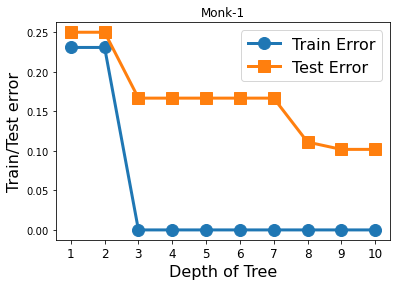

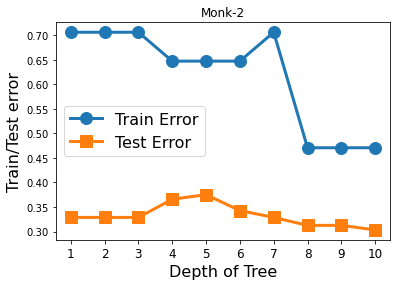

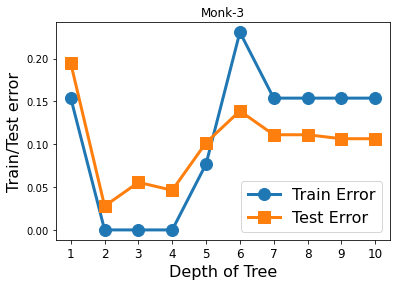

In [3]:
from sklearn.model_selection import train_test_split
def learning_curve(Xtrn, ytrn, Xtst, ytst, title):
    train_er={}
    test_er={}
    val_frac = 0.1
    Xtrn, Xval, ytrn, yval = train_test_split(Xtrn, ytrn, test_size=val_frac, random_state=42)

    for i in range(1,11):
        decision_tree = id3(Xtrn, ytrn, max_depth=i)
        y_pred_trn = [predict_example(x, decision_tree) for x in Xval]
        trn_err = compute_error(yval, y_pred_trn)
        train_er[i] = trn_err
        y_pred_tst = [predict_example(x, decision_tree) for x in Xtst]
        tst_err = compute_error(ytst, y_pred_tst)
        test_er[i] = tst_err

    plt.figure()
    plt.title(title)
    plt.plot(train_er.keys(), train_er.values(), marker='o', linewidth=3, markersize=12)
    plt.plot(test_er.keys(), test_er.values(), marker='s', linewidth=3, markersize=12)
    plt.xlabel('Depth of Tree', fontsize=16)
    plt.ylabel('Train/Test error', fontsize=16)
    plt.xticks(list(train_er.keys()), fontsize=12)
    plt.legend(['Train Error', 'Test Error'], fontsize=16)
    plt.show()

for i in range(1,4):
    fname = './monks-'+str(i)+'.train'
    M = np.genfromtxt(fname, missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytrn = M[:, 0]
    Xtrn = M[:, 1:]

    fname = './monks-'+str(i)+'.test'
    M = np.genfromtxt(fname, missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytst = M[:, 0]
    Xtst = M[:, 1:]

    learning_curve(Xtrn, ytrn, Xtst, ytst,'Monk-'+str(i))

## C) Weak Learners

In [4]:
M = np.genfromtxt('./monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

# Load the test data
M = np.genfromtxt('./monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

d = [1,3,5]
for i in d:
    print('For Depth: ',i)
    decision_tree = id3(Xtrn, ytrn, max_depth=i)

    pretty_print(decision_tree)

    dot_str = to_graphviz(decision_tree)
    render_dot_file(dot_str, './my_learned_tree'+ str(i))

    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)
    print('\n Confusion Matrix:\n',confusion_matrix(ytst, y_pred))

    print('Test Error = {0:4.2f}%.'.format(tst_err * 100))
    print('\n\n\n')

For Depth:  1
TREE
+-- [SPLIT: x4 = 1 False]
|	+-- [LABEL = 0]
+-- [SPLIT: x4 = 1 True]
|	+-- [LABEL = 1]

 Confusion Matrix:
 [[216   0]
 [108 108]]
Test Error = 25.00%.




For Depth:  3
TREE
+-- [SPLIT: x4 = 1 False]
|	+-- [SPLIT: x0 = 1 True]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 1]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [LABEL = 0]
|	+-- [SPLIT: x0 = 1 False]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [LABEL = 1]
+-- [SPLIT: x4 = 1 True]
|	+-- [LABEL = 1]

 Confusion Matrix:
 [[144  72]
 [  0 216]]
Test Error = 16.67%.




For Depth:  5
TREE
+-- [SPLIT: x4 = 1 False]
|	+-- [SPLIT: x0 = 1 True]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 1]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [LABEL = 0]
|	+-- [SPLIT: x0 = 1 False]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [SPLIT: x4 = 3 False]
|	|	|	|	+-- [SPLIT: x3 = 1 True]
|	|	|	|	|	+-- [LABEL = 1]
|	|	|	|	+-- [SPLIT: x3 = 1 False

## D) scikit-learn Decision Tree

For Depth 1
Test Error =  0.75 

Confusion Matrix:
 [[216   0]
 [108 108]] 



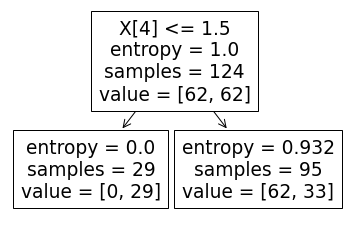

For Depth 3
Test Error =  0.8333333333333334 

Confusion Matrix:
 [[144  72]
 [  0 216]] 



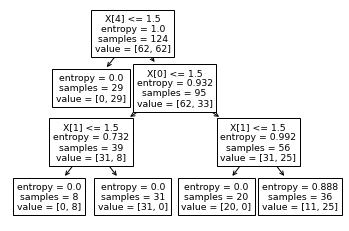

For Depth 5
Test Error =  0.8333333333333334 

Confusion Matrix:
 [[168  48]
 [ 24 192]] 



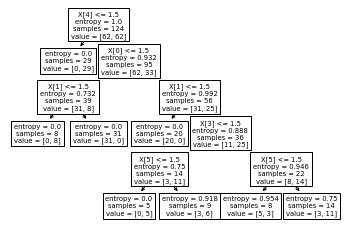

In [5]:
from sklearn import tree
from sklearn.metrics import accuracy_score

M = np.genfromtxt('./monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytrn = M[:, 0]
Xtrn = M[:, 1:]

# Load the test data
M = np.genfromtxt('./monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
ytst = M[:, 0]
Xtst = M[:, 1:]

depth  = [1,3,5]
for i in depth:
    print('For Depth', i)
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    model = model.fit(Xtrn, ytrn)
    predi = model.predict(Xtst)
    acc_test = accuracy_score(ytst, predi)
    print('Test Error = ',acc_test,'\n')
    print('Confusion Matrix:\n',confusion_matrix(ytst, predi),'\n') 
    tree.plot_tree(model)
    plt.show()


## E) Other Data Sets

On own Id3 for depth1
TREE
+-- [SPLIT: x2 = 1 False]
|	+-- [LABEL = 1]
+-- [SPLIT: x2 = 1 True]
|	+-- [LABEL = 0]

Confusion Matrix:
 [[24 57]
 [ 5 87]]
Test Error = 35.84%.
----------------------------------


 Through scikit learn
Confusion Matrix:
 [[40 41]
 [19 73]] 

Test Error =  0.653179190751445 



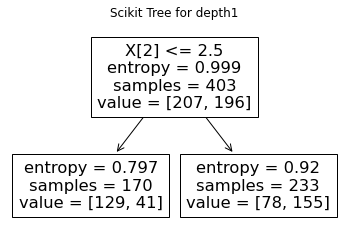

On own Id3 for depth3
TREE
+-- [SPLIT: x2 = 1 False]
|	+-- [SPLIT: x1 = 1 True]
|	|	+-- [SPLIT: x3 = 1 True]
|	|	|	+-- [LABEL = 1]
|	|	+-- [SPLIT: x3 = 1 False]
|	|	|	+-- [LABEL = 1]
|	+-- [SPLIT: x1 = 1 False]
|	|	+-- [SPLIT: x0 = 1 False]
|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x0 = 1 True]
|	|	|	+-- [LABEL = 1]
+-- [SPLIT: x2 = 1 True]
|	+-- [SPLIT: x0 = 1 False]
|	|	+-- [SPLIT: x1 = 1 False]
|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x1 = 1 True]
|	|	|	+-- [LABEL = 0]
|	+-- [SPLIT: x0 = 1 True]
|	|	+-- [SPLIT: x3 = 1 False]
|	|	|	+-- [LABEL = 1]
|	|	+-- [SPLIT: x3 = 1 True]
|	|	|	+-- [LABEL = 0]

Confusion Matrix:
 [[76  5]
 [36 56]]
Test Error = 23.70%.
----------------------------------


 Through scikit learn
Confusion Matrix:
 [[62 19]
 [13 79]] 

Test Error =  0.815028901734104 



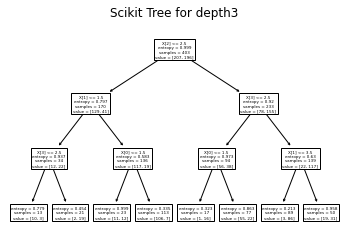

On own Id3 for depth5
TREE
+-- [SPLIT: x2 = 1 False]
|	+-- [SPLIT: x1 = 1 True]
|	|	+-- [SPLIT: x3 = 1 True]
|	|	|	+-- [SPLIT: x0 = 5 False]
|	|	|	|	+-- [SPLIT: x2 = 2 True]
|	|	|	|	|	+-- [LABEL = 0]
|	|	|	|	+-- [SPLIT: x2 = 2 False]
|	|	|	|	|	+-- [LABEL = 1]
|	|	|	+-- [SPLIT: x0 = 5 True]
|	|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x3 = 1 False]
|	|	|	+-- [SPLIT: x3 = 2 True]
|	|	|	|	+-- [SPLIT: x0 = 5 False]
|	|	|	|	|	+-- [LABEL = 1]
|	|	|	|	+-- [SPLIT: x0 = 5 True]
|	|	|	|	|	+-- [LABEL = 0]
|	|	|	+-- [SPLIT: x3 = 2 False]
|	|	|	|	+-- [LABEL = 1]
|	+-- [SPLIT: x1 = 1 False]
|	|	+-- [SPLIT: x0 = 1 False]
|	|	|	+-- [SPLIT: x3 = 1 False]
|	|	|	|	+-- [SPLIT: x2 = 2 False]
|	|	|	|	|	+-- [LABEL = 1]
|	|	|	|	+-- [SPLIT: x2 = 2 True]
|	|	|	|	|	+-- [LABEL = 0]
|	|	|	+-- [SPLIT: x3 = 1 True]
|	|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x0 = 1 True]
|	|	|	+-- [SPLIT: x3 = 1 False]
|	|	|	|	+-- [SPLIT: x2 = 2 False]
|	|	|	|	|	+-- [LABEL = 1]
|	|	|	|	+-- [SPLIT: x2 = 2 True]
|	|	|	|	|	+-- [LABEL = 1]
|	|	|

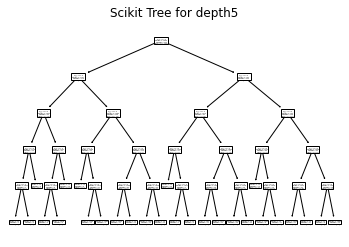

In [7]:
M = np.genfromtxt('./balance-scale.data', missing_values=0, skip_header=0, delimiter=',', dtype=str)
ytrn = M[:, 0]
Xtrn = M[:, 1:5]
s= 0
val= np.unique(ytrn,  return_counts=False)
for j in range(len(val)):
    x = np.where(ytrn==val[j])
    s = s + len(x)
    if val[j]=='R':
        ytrn[x] = 1
    elif val[j]=='L':
        ytrn[x] = 0


ytrn = ytrn.astype(int)
Xtrn = Xtrn.astype(int)

Xtrn, Xtst, ytrn, ytst = train_test_split(Xtrn, ytrn, test_size=0.3, random_state=42)

depth  = [1,3,5]
for i in depth:
    print("On own Id3 for depth" + str(i))
    decision_tree = id3(Xtrn, ytrn, max_depth=i)
    pretty_print(decision_tree)

    dot_str = to_graphviz(decision_tree)
    render_dot_file(dot_str, './my_learned_tree_own_data'+ str(i))

    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)
    print('\nConfusion Matrix:\n',confusion_matrix(ytst, y_pred))
    print('Test Error = {0:4.2f}%.'.format(tst_err * 100))
    print("----------------------------------")
    
    print("\n\n Through scikit learn")
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
    model = model.fit(Xtrn, ytrn)
    predi = model.predict(Xtst)
    acc_test = accuracy_score(ytst, predi)
    print('Confusion Matrix:\n',confusion_matrix(ytst, predi),'\n')
    print('Test Error = ',acc_test,'\n')
    tree.plot_tree(model)
    plt.title('Scikit Tree for depth'+str(i))
    plt.savefig(str(i))
    plt.show()
    
